<a href="https://colab.research.google.com/github/anmolsabharwal/RedDevils/blob/master/RD_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
from google.colab import drive
import datetime
import plotly.figure_factory as ff


drive.mount('/content/drive')
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
gws = sqlite3.connect('/content/drive/My Drive/fpl.db')
gws = pd.read_sql_query("SELECT * FROM gw",gws)
#gws1=pd.read_csv(io.StringIO(uploaded['gws.csv'].decode('utf-8')),sep=',')
gws.head()

,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards
0,Aaron Cresswell,0,0,0,0,0,454,10,0,0,0,0,2016-08-15T19:00:00Z,0,4,0,0,0,0,1,0,14023,1,2,0,0,0,0,0,55,FALSE,0
1,Aaron Lennon,0,0,6,0,0.3,142,3,0,0,0.9,8.2,2016-08-13T14:00:00Z,15,17,0,0,0,0,1,0,13918,1,1,0,1,0,0,0,60,TRUE,0
2,Aaron Ramsey,0,0,5,0,4.9,16,8,3,0,3,2.2,2016-08-14T15:00:00Z,60,9,0,0,0,0,1,0,163170,4,3,23,2,0,0,0,80,TRUE,0
3,Abdoulaye Doucour�,0,0,0,0,0,482,7,0,0,0,0,2016-08-13T14:00:00Z,0,13,0,0,0,0,1,0,1051,1,1,0,0,0,0,0,50,FALSE,0
4,Abdul Rahman Baba,0,0,0,0,0,80,10,0,0,0,0,2016-08-15T19:00:00Z,0,20,0,0,0,0,1,0,1243,1,2,0,0,0,0,0,55,TRUE,0


In [55]:
gws.columns

Index(['name', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity',
       'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index',
       'influence', 'kickoff_time', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
       'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards'],
      dtype='object')

In [56]:
gws=gws.astype({'name':'category','assists':int, 'bonus':int, 'bps':int, 'clean_sheets':'category',
       'creativity':float,'element':int,'goals_conceded':int,
       'goals_scored':int, 'ict_index':float, 'influence':float,'minutes':int, 'opponent_team':int, 'own_goals':int,'penalties_missed':int, 'penalties_saved':int,
       'red_cards':int, 'round':int, 'saves':int, 'selected':int,
        'team_a_score':int, 'team_h_score':int,'threat':float,
       'total_points':int, 'transfers_balance':int, 'transfers_in':int, 'transfers_out':int,
       'value':int, 'yellow_cards':int})

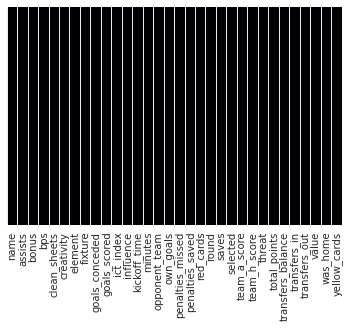

In [57]:
sns.set_style('dark')
sns.heatmap(gws.isnull(),yticklabels=False,cbar=False,cmap='inferno')

In [58]:
gws = gws.assign(id=(gws['name']).astype('category').cat.codes)


In [59]:
def fd(x):
  x=int(x)
  if x<=6:
    return '3'
  elif x>6 and x<=14:
    return '1'
  else:
    return '2'

In [60]:
gws.rename(columns={'opponent_team':'fdr'},inplace=True)


In [61]:
gws['fdr']=gws['fdr'].apply(fd).astype(float)


In [62]:
gws['kickoff_time']=pd.to_datetime(gws['kickoff_time'])

In [63]:
gws['kickoff_time'] = gws.kickoff_time.dt.hour


In [64]:
def time(x):
  x=int(x)
  if x>8 and x<=12:
    return '0'
  elif x>12 and x<=18:
    return '1'
  else:
    return '2'

In [65]:
gws['kickoff_time']=gws['kickoff_time'].apply(time).astype(float)
gws.head(20)

,name,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,id
0,Aaron Cresswell,0,0,0,0,0.0,454,10,0,0,0.0,0.0,2.0,0,3.0,0,0,0,0,1,0,14023,1,2,0.0,0,0,0,0,55,FALSE,0,629
1,Aaron Lennon,0,0,6,0,0.3,142,3,0,0,0.9,8.2,1.0,15,2.0,0,0,0,0,1,0,13918,1,1,0.0,1,0,0,0,60,TRUE,0,630
2,Aaron Ramsey,0,0,5,0,4.9,16,8,3,0,3.0,2.2,1.0,60,1.0,0,0,0,0,1,0,163170,4,3,23.0,2,0,0,0,80,TRUE,0,633
3,Abdoulaye Doucour�,0,0,0,0,0.0,482,7,0,0,0.0,0.0,1.0,0,1.0,0,0,0,0,1,0,1051,1,1,0.0,0,0,0,0,50,FALSE,0,636
4,Abdul Rahman Baba,0,0,0,0,0.0,80,10,0,0,0.0,0.0,2.0,0,2.0,0,0,0,0,1,0,1243,1,2,0.0,0,0,0,0,55,TRUE,0,637
5,Abel Hern�ndez,1,0,10,0,12.2,163,4,1,0,5.7,14.4,0.0,90,1.0,0,0,0,0,1,0,26039,1,2,30.0,5,0,0,0,60,TRUE,0,638
6,Adama Diomande,0,2,29,0,16.8,164,4,1,1,10.7,45.2,0.0,90,1.0,0,0,0,0,1,0,38151,1,2,45.0,8,0,0,0,45,TRUE,0,647
7,Adam Clayton,0,0,6,0,2.2,283,6,1,0,1.4,3.2,1.0,90,1.0,0,0,0,0,1,0,17663,1,1,9.0,2,0,0,0,45,TRUE,0,639
8,Adam Federici,0,0,0,0,0.0,30,9,0,0,0.0,0.0,0.0,0,1.0,0,0,0,0,1,0,4315,3,1,0.0,0,0,0,0,45,TRUE,0,640
9,Adam Forshaw,0,0,3,0,1.3,286,6,1,0,0.3,2.0,1.0,69,1.0,0,0,0,0,1,0,2723,1,1,0.0,1,0,0,0,45,TRUE,1,641


In [66]:
def was_home(x):
  if x=="FALSE":
    #print('Away')
    return str('Away')
  else:
    #print('Home')
    return str('Home')

In [67]:
gws['home']=gws['was_home'].apply(was_home)

In [68]:
gws.drop(['element','fixture','round','transfers_balance','transfers_in','transfers_out','team_a_score','was_home',	'team_h_score','round'],axis=1, inplace=True)

In [69]:
gws['value']=gws['value']*0.1


In [70]:
def points(x):
  if x<=2:
    return 1
  elif x>2 and x<=7:
    return 2
  elif x>7 and x<=10:
    return 3
  else:
    return 4


In [71]:
gws['points']=gws['total_points'].apply(points)
gws1=gws.copy()

In [72]:
gws1['Last_Week_Points'] = gws1.groupby(['id'])['points'].shift().astype(float)
gws1['Last_2_Week_Points'] = gws1.groupby(['id'])['points'].shift(2).astype(float)
#gws1['Last_3_Week_Points'] = gws1.groupby(['id'])['total_points'].shift(3).astype(float)
#gws1['Last_4_Week_Points'] = gws1.groupby(['id'])['total_points'].shift(4).astype(float)



gws1['Last_Week_Goals'] = gws1.groupby(['id'])['goals_scored'].shift().astype(float)
gws1['Last_2_Week_Goals'] = gws1.groupby(['id'])['goals_scored'].shift(2).astype(float)
#gws1['Last_3_Week_Goals'] = gws1.groupby(['id'])['goals_scored'].shift(3).astype(float)


gws1['Last_Week_ICT'] = gws1.groupby(['id'])['ict_index'].shift().astype(float)
gws1['Last_2_Week_ICT'] = gws1.groupby(['id'])['ict_index'].shift(2).astype(float)
# #gws1['Last_3_Week_ICT'] = gws1.groupby(['id'])['ict_index'].shift(3).astype(float)


gws1['Last_Week_BPS'] = gws1.groupby(['id'])['bps'].shift().astype(float)
gws1['Last_2_Week_BPS'] = gws1.groupby(['id'])['bps'].shift(2).astype(float)
#gws1['Last_3_Week_BPS'] = gws1.groupby(['id'])['bps'].shift(3).astype(float)


gws1['Last_Week_Assists'] = gws1.groupby(['id'])['assists'].shift().astype(float)
gws1['Last_2_Week_Assists'] = gws1.groupby(['id'])['assists'].shift(2).astype(float)
#gws1['Last_3_Week_Assists'] = gws1.groupby(['id'])['assists'].shift(3).astype(float)


gws1['Last_Week_Bonus'] = gws1.groupby(['id'])['bonus'].shift().astype(float)
gws1['Last_2_Week_Bonus'] = gws1.groupby(['id'])['bonus'].shift(2).astype(float)
#gws1['Last_3_Week_Bonus'] = gws1.groupby(['id'])['bonus'].shift(3).astype(float)


gws1['Last_Week_Influence'] = gws1.groupby(['id'])['influence'].shift().astype(float)
gws1['Last_2_Week_Influence'] = gws1.groupby(['id'])['influence'].shift(2).astype(float)
#gws1['Last_3_Week_Influence'] = gws1.groupby(['id'])['influence'].shift(3).astype(float)


gws1['Last_Week_Minutes_Played'] = gws1.groupby(['id'])['minutes'].shift().astype(float)
gws1['Last_2_Week_Minutes_Played'] = gws1.groupby(['id'])['minutes'].shift(2).astype(float)
#gws1['Last_3_Week_Minutes_Played'] = gws1.groupby(['id'])['minutes'].shift(3).astype(float)


gws1['Last_Week_Threat'] = gws1.groupby(['id'])['threat'].shift().astype(float)
gws1['Last_2_Week_Threat'] = gws1.groupby(['id'])['threat'].shift(2).astype(float)
# #gws1['Last_3_Week_Threat'] = gws1.groupby(['id'])['threat'].shift(3).astype(float)


gws1['Last_Week_Selected'] = gws1.groupby(['id'])['selected'].shift().astype(float)
gws1['Last_2_Week_Selected'] = gws1.groupby(['id'])['selected'].shift(2).astype(float)
#gws1['Last_3_Week_Selected'] = gws1.groupby(['id'])['selected'].shift(3).astype(float)


gws1['Last_Week_Value'] = gws1.groupby(['id'])['value'].shift().astype(float)
gws1['Last_2_Week_Value'] = gws1.groupby(['id'])['value'].shift(2).astype(float)
# gws1['Last_3_Week_Value'] = gws1.groupby(['id'])['value'].shift(3).astype(float)


gws1['Last_Week_Creativity'] = gws1.groupby(['id'])['creativity'].shift().astype(float)
gws1['Last_2_Week_Creativity'] = gws1.groupby(['id'])['creativity'].shift(2).astype(float)
# #gws1['Last_3_Week_Creativity'] = gws1.groupby(['id'])['creativity'].shift(3).astype(float)



gws1['Last_Week_FDR'] = gws1.groupby(['id'])['fdr'].shift().astype(float).astype(float)
gws1['Last_2_Week_FDR'] = gws1.groupby(['id'])['fdr'].shift(2).astype(float).astype(float)
gws1['Last_3_Week_FDR'] = gws1.groupby(['id'])['fdr'].shift(3).astype(float).astype(float)


gws1['Last_Week_Clean_Sheets'] = gws1.groupby(['id'])['clean_sheets'].shift().astype(float)
gws1['Last_2_Week_Clean_Sheets'] = gws1.groupby(['id'])['clean_sheets'].shift(2).astype(float)
#gws1['Last_3_Week_Clean_Sheets'] = gws1.groupby(['id'])['clean_sheets'].shift(3).astype(float)


gws1['Last_Week_Goals_Conceded'] = gws1.groupby(['id'])['goals_conceded'].shift().astype(float)
gws1['Last_2_Week_Goals_Conceded'] = gws1.groupby(['id'])['goals_conceded'].shift(2).astype(float)
#gws1['Last_3_Week_Goals_Conceded'] = gws1.groupby(['id'])['goals_conceded'].shift(3).astype(float)


# gws1['Last_Week_Kickoff_Time'] = gws1.groupby(['id'])['kickoff_time'].shift().astype(float)
# gws1['Last_2_Week_Kickoff_Time'] = gws1.groupby(['id'])['kickoff_time'].shift(2).astype(float)
# gws1['Last_3_Week_Kickoff_Time'] = gws1.groupby(['id'])['kickoff_time'].shift(3).astype(float)


gws1['Last_Week_Own_Goals'] = gws1.groupby(['id'])['own_goals'].shift().astype(float)
gws1['Last_2_Week_Own_Goals'] = gws1.groupby(['id'])['own_goals'].shift(2).astype(float)
# gws1['Last_3_Week_Own_Goals'] = gws1.groupby(['id'])['own_goals'].shift(3).astype(float)


gws1['Last_Week_Penalties_Missed'] = gws1.groupby(['id'])['penalties_missed'].shift().astype(float)
gws1['Last_2_Week_Penalties_Missed'] = gws1.groupby(['id'])['penalties_missed'].shift(2).astype(float)
# gws1['Last_3_Week_Penalties_Saved'] = gws1.groupby(['id'])['penalties_saved'].shift(3).astype(float)


gws1['Last_Week_Red_Cards'] = gws1.groupby(['id'])['red_cards'].shift().astype(float)
gws1['Last_2_Week_Red_Cards'] = gws1.groupby(['id'])['red_cards'].shift(2).astype(float)
# gws1['Last_3_Week_Red_Cards'] = gws1.groupby(['id'])['red_cards'].shift(3).astype(float)


gws1['Last_Week_Saves'] = gws1.groupby(['id'])['saves'].shift()
gws1['Last_2_Week_Saves'] = gws1.groupby(['id'])['saves'].shift(2)
#gws1['Last_3_Week_Saves'] = gws1.groupby(['id'])['saves'].shift(3)


gws1['Last_Week_Yellow_Cards'] = gws1.groupby(['id'])['yellow_cards'].shift()
gws1['Last_2_Week_Yellow_Cards'] = gws1.groupby(['id'])['yellow_cards'].shift(2)
# gws1['Last_3_Week_Yellow_Cards'] = gws1.groupby(['id'])['yellow_cards'].shift(3)


# gws1['Last_Week_Home'] = gws1.groupby(['id'])['home'].shift()
# gws1['Last_2_Week_Home'] = gws1.groupby(['id'])['home'].shift(2)
# gws1['Last_3_Week_Home'] = gws1.groupby(['id'])['home'].shift(3)


gws1.head(100)

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,id,home,points,Last_Week_Points,Last_2_Week_Points,Last_Week_Goals,Last_2_Week_Goals,Last_Week_ICT,Last_2_Week_ICT,Last_Week_BPS,Last_2_Week_BPS,Last_Week_Assists,Last_2_Week_Assists,Last_Week_Bonus,Last_2_Week_Bonus,Last_Week_Influence,Last_2_Week_Influence,Last_Week_Minutes_Played,Last_2_Week_Minutes_Played,Last_Week_Threat,Last_2_Week_Threat,Last_Week_Selected,Last_2_Week_Selected,Last_Week_Value,Last_2_Week_Value,Last_Week_Creativity,Last_2_Week_Creativity,Last_Week_FDR,Last_2_Week_FDR,Last_3_Week_FDR,Last_Week_Clean_Sheets,Last_2_Week_Clean_Sheets,Last_Week_Goals_Conceded,Last_2_Week_Goals_Conceded,Last_Week_Own_Goals,Last_2_Week_Own_Goals,Last_Week_Penalties_Missed,Last_2_Week_Penalties_Missed,Last_Week_Red_Cards,Last_2_Week_Red_Cards,Last_Week_Saves,Last_2_Week_Saves,Last_Week_Yellow_Cards,Last_2_Week_Yellow_Cards
0,Aaron Cresswell,0,0,0,0,0.0,0,0,0.0,0.0,2.0,0,3.0,0,0,0,0,0,14023,0.0,0,5.5,0,629,Away,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aaron Lennon,0,0,6,0,0.3,0,0,0.9,8.2,1.0,15,2.0,0,0,0,0,0,13918,0.0,1,6.0,0,630,Home,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Ramsey,0,0,5,0,4.9,3,0,3.0,2.2,1.0,60,1.0,0,0,0,0,0,163170,23.0,2,8.0,0,633,Home,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Abdoulaye Doucour�,0,0,0,0,0.0,0,0,0.0,0.0,1.0,0,1.0,0,0,0,0,0,1051,0.0,0,5.0,0,636,Away,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Abdul Rahman Baba,0,0,0,0,0.0,0,0,0.0,0.0,2.0,0,2.0,0,0,0,0,0,1243,0.0,0,5.5,0,637,Home,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Abel Hern�ndez,1,0,10,0,12.2,1,0,5.7,14.4,0.0,90,1.0,0,0,0,0,0,26039,30.0,5,6.0,0,638,Home,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Adama Diomande,0,2,29,0,16.8,1,1,10.7,45.2,0.0,90,1.0,0,0,0,0,0,38151,45.0,8,4.5,0,647,Home,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Adam Clayton,0,0,6,0,2.2,1,0,1.4,3.2,1.0,90,1.0,0,0,0,0,0,17663,9.0,2,4.5,0,639,Home,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Adam Federici,0,0,0,0,0.0,0,0,0.0,0.0,0.0,0,1.0,0,0,0,0,0,4315,0.0,0,4.5,0,640,Home,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Adam Forshaw,0,0,3,0,1.3,1,0,0.3,2.0,1.0,69,1.0,0,0,0,0,0,2723,0.0,1,4.5,1,641,Home,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
home=pd.get_dummies(gws1['home'])
gws1=pd.concat([gws1,home],axis=1)
gws1.head()

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,id,home,points,Last_Week_Points,Last_2_Week_Points,Last_Week_Goals,Last_2_Week_Goals,Last_Week_ICT,Last_2_Week_ICT,Last_Week_BPS,Last_2_Week_BPS,Last_Week_Assists,Last_2_Week_Assists,Last_Week_Bonus,Last_2_Week_Bonus,Last_Week_Influence,Last_2_Week_Influence,Last_Week_Minutes_Played,Last_2_Week_Minutes_Played,Last_Week_Threat,Last_2_Week_Threat,Last_Week_Selected,Last_2_Week_Selected,Last_Week_Value,Last_2_Week_Value,Last_Week_Creativity,Last_2_Week_Creativity,Last_Week_FDR,Last_2_Week_FDR,Last_3_Week_FDR,Last_Week_Clean_Sheets,Last_2_Week_Clean_Sheets,Last_Week_Goals_Conceded,Last_2_Week_Goals_Conceded,Last_Week_Own_Goals,Last_2_Week_Own_Goals,Last_Week_Penalties_Missed,Last_2_Week_Penalties_Missed,Last_Week_Red_Cards,Last_2_Week_Red_Cards,Last_Week_Saves,Last_2_Week_Saves,Last_Week_Yellow_Cards,Last_2_Week_Yellow_Cards,Away,Home
0,Aaron Cresswell,0,0,0,0,0.0,0,0,0.0,0.0,2.0,0,3.0,0,0,0,0,0,14023,0.0,0,5.5,0,629,Away,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
1,Aaron Lennon,0,0,6,0,0.3,0,0,0.9,8.2,1.0,15,2.0,0,0,0,0,0,13918,0.0,1,6.0,0,630,Home,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,Aaron Ramsey,0,0,5,0,4.9,3,0,3.0,2.2,1.0,60,1.0,0,0,0,0,0,163170,23.0,2,8.0,0,633,Home,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
3,Abdoulaye Doucour�,0,0,0,0,0.0,0,0,0.0,0.0,1.0,0,1.0,0,0,0,0,0,1051,0.0,0,5.0,0,636,Away,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
4,Abdul Rahman Baba,0,0,0,0,0.0,0,0,0.0,0.0,2.0,0,2.0,0,0,0,0,0,1243,0.0,0,5.5,0,637,Home,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1


In [74]:
hpm =gws1.groupby('id',as_index=False)['total_points'].expanding().sum()/gws1.groupby('id',as_index=False)['Home'].expanding().sum()
gws1["Home Points"] = hpm.reset_index(level=0, drop=True)

apm =gws1.groupby('id',as_index=False)['total_points'].expanding().sum()/gws1.groupby('id',as_index=False)['Away'].expanding().sum()
gws1["Away Points"] = apm.reset_index(level=0, drop=True)

ppm =gws1.groupby('id',as_index=False)['total_points'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90
gws1["Points_90"] = ppm.reset_index(level=0, drop=True)

vm =gws1.groupby('id',as_index=False)['value'].expanding().sum()/gws1.groupby('id',as_index=False)['total_points'].expanding().sum()*90
gws1["Value_Point"] = vm.reset_index(level=0, drop=True)

apm =gws1.groupby('id',as_index=False)['assists'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90
gws1["Assists_90"] = ppm.reset_index(level=0, drop=True)

gpm =gws1.groupby('id',as_index=False)['goals_scored'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90
gws1["Goals_90"] = gpm.reset_index(level=0, drop=True)

ipm =gws1.groupby('id',as_index=False)['influence'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90
gws1["Influence_90"] = ipm.reset_index(level=0, drop=True)

bpm =gws1.groupby('id',as_index=False)['bps'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()*90
gws1["BPS_90"] = ipm.reset_index(level=0, drop=True)

ih =gws1.groupby('id',as_index=False)['influence'].expanding().sum()/gws1.groupby('id',as_index=False)['Home'].expanding().sum()
gws1["Home Influence"] = ih.reset_index(level=0, drop=True)

ah =gws1.groupby('id',as_index=False)['influence'].expanding().sum()/gws1.groupby('id',as_index=False)['Away'].expanding().sum()
gws1["Away Influence"] = ah.reset_index(level=0, drop=True)

hg =gws1.groupby('id',as_index=False)['goals_scored'].expanding().sum()/gws1.groupby('id',as_index=False)['Home'].expanding().sum()
gws1["Home Goals"] = hg.reset_index(level=0, drop=True)

ag =gws1.groupby('id',as_index=False)['goals_scored'].expanding().sum()/gws1.groupby('id',as_index=False)['Away'].expanding().sum()
gws1["Clean Sheets_90"] = ag.reset_index(level=0, drop=True)

cs =gws1.groupby('id',as_index=False)['clean_sheets'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()
gws1["Points_90"] = cs.reset_index(level=0, drop=True)

gc =gws1.groupby('id',as_index=False)['goals_conceded'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()
gws1["Goals_Conceded_90"] = gc.reset_index(level=0, drop=True)

s =gws1.groupby('id',as_index=False)['saves'].expanding().sum()/gws1.groupby('id',as_index=False)['minutes'].expanding().sum()
gws1["Saves_90"] = s.reset_index(level=0, drop=True)

sh =gws1.groupby('id',as_index=False)['saves'].expanding().sum()/gws1.groupby('id',as_index=False)['Home'].expanding().sum()
gws1["Saves Home"] = sh.reset_index(level=0, drop=True)

sa =gws1.groupby('id',as_index=False)['saves'].expanding().sum()/gws1.groupby('id',as_index=False)['Away'].expanding().sum()
gws1["Saves Away"] = sa.reset_index(level=0, drop=True)

ch =gws1.groupby('id',as_index=False)['creativity'].expanding().sum()/gws1.groupby('id',as_index=False)['Home'].expanding().sum()
gws1["Creativity Home"] = ch.reset_index(level=0, drop=True)

ca =gws1.groupby('id',as_index=False)['creativity'].expanding().sum()/gws1.groupby('id',as_index=False)['Away'].expanding().sum()
gws1["Creativity Away"] = ca.reset_index(level=0, drop=True)

csh =gws1.groupby('id',as_index=False)['clean_sheets'].expanding().sum()/gws1.groupby('id',as_index=False)['Home'].expanding().sum()
gws1["Clean Sheets Home"] = csh.reset_index(level=0, drop=True)

csa =gws1.groupby('id',as_index=False)['clean_sheets'].expanding().sum()/gws1.groupby('id',as_index=False)['Away'].expanding().sum()
gws1["Clean Sheets Away"] = csa.reset_index(level=0, drop=True)

bph =gws1.groupby('id',as_index=False)['bonus'].expanding().sum()/gws1.groupby('id',as_index=False)['Home'].expanding().sum()
gws1['Bonus Home'] = bph.reset_index(level=0, drop=True)

bpa =gws1.groupby('id',as_index=False)['bonus'].expanding().sum()/gws1.groupby('id',as_index=False)['Away'].expanding().sum()
gws1["Bonus Away"] = bpa.reset_index(level=0, drop=True)

icth =gws1.groupby('id',as_index=False)['ict_index'].expanding().sum()/gws1.groupby('id',as_index=False)['Home'].expanding().sum()
gws1['ICT Home'] = icth.reset_index(level=0, drop=True)

icta =gws1.groupby('id',as_index=False)['ict_index'].expanding().sum()/gws1.groupby('id',as_index=False)['Away'].expanding().sum()
gws1["ICT Away"] = icta.reset_index(level=0, drop=True)

ah =gws1.groupby('id',as_index=False)['assists'].expanding().sum()/gws1.groupby('id',as_index=False)['Home'].expanding().sum()
gws1['Assists Home'] = ah.reset_index(level=0, drop=True)

aa =gws1.groupby('id',as_index=False)['ict_index'].expanding().sum()/gws1.groupby('id',as_index=False)['Away'].expanding().sum()
gws1["Assists Away"] = aa.reset_index(level=0, drop=True)


In [75]:
def f(df):
    df['Goalstreak'] = (df['goals_scored'] > 0).cumsum()
    df['cumsum'] = np.nan
    df.loc[df['assists'] == 0, 'cumsum'] = df['Goalstreak']
    df['cumsum'] = df['cumsum'].fillna(method='ffill')
    df['cumsum'] = df['cumsum'].fillna(0)
    df['Goal Streak'] = df['Goalstreak'] - df['cumsum']
    df.drop(['Goalstreak', 'cumsum'], axis=1, inplace=True)
    df['Goal Streak']=df['Goal Streak'].shift(1)
    return df

In [76]:
gws1=gws1.groupby('id').apply(f)

In [77]:
def f(df):
    df['Assiststreak'] = (df['assists'] > 0).cumsum()
    df['cumsum'] = np.nan
    df.loc[df['assists'] == 0, 'cumsum'] = df['Assiststreak']
    df['cumsum'] = df['cumsum'].fillna(method='ffill')
    df['cumsum'] = df['cumsum'].fillna(0)
    df['Assist Streak'] = df['Assiststreak'] - df['cumsum']
    df.drop(['Assiststreak', 'cumsum'], axis=1, inplace=True)
    df['Assist Streak']=df['Assist Streak'].shift(1)
    return df

In [78]:
gws1=gws1.groupby('id').apply(f)

In [79]:
# gws1 = gws1[gws1['minutes'] > 0] 


In [80]:
gws1=gws1.replace([np.inf, -np.inf], np.nan)

gws1=gws1.dropna()
gws1.head(100)

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,fdr,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,threat,total_points,value,yellow_cards,id,home,points,Last_Week_Points,Last_2_Week_Points,Last_Week_Goals,Last_2_Week_Goals,Last_Week_ICT,Last_2_Week_ICT,Last_Week_BPS,Last_2_Week_BPS,Last_Week_Assists,Last_2_Week_Assists,Last_Week_Bonus,Last_2_Week_Bonus,Last_Week_Influence,Last_2_Week_Influence,...,Last_Week_Own_Goals,Last_2_Week_Own_Goals,Last_Week_Penalties_Missed,Last_2_Week_Penalties_Missed,Last_Week_Red_Cards,Last_2_Week_Red_Cards,Last_Week_Saves,Last_2_Week_Saves,Last_Week_Yellow_Cards,Last_2_Week_Yellow_Cards,Away,Home,Home Points,Away Points,Points_90,Value_Point,Assists_90,Goals_90,Influence_90,BPS_90,Home Influence,Away Influence,Home Goals,Clean Sheets_90,Goals_Conceded_90,Saves_90,Saves Home,Saves Away,Creativity Home,Creativity Away,Clean Sheets Home,Clean Sheets Away,Bonus Home,Bonus Away,ICT Home,ICT Away,Assists Home,Assists Away,Goal Streak,Assist Streak
1721,Aaron Cresswell,0,0,13,0,2.8,3,0,1.3,8.4,1.0,90,2.0,0,0,0,0,0,16187,2.0,1,5.3,0,629,Away,1,1.0,1.0,0.0,0.0,2.0,1.3,13.0,12.0,0.0,0.0,0.0,0.0,14.4,5.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,4.000000,1.333333,0.000000,481.500000,1.333333,0.000000,9.400000,9.400000,28.200000,9.400000,0.000000,0.000000,0.022222,0.000000,0.0,0.000000,12.600000,4.200000,0.000000,0.000000,0.000000,0.000000,4.600000,1.533333,0.000000,1.533333,0.0,0.0
1722,Aaron Lennon,0,0,6,0,3.2,1,0,0.6,0.0,1.0,65,2.0,0,0,0,0,0,7501,4.0,2,5.6,0,630,Home,1,1.0,1.0,0.0,0.0,0.7,0.4,6.0,6.0,0.0,0.0,0.0,0.0,5.6,3.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1.666667,5.000000,0.000000,410.400000,3.913043,0.000000,13.304348,13.304348,5.666667,17.000000,0.000000,0.000000,0.017391,0.000000,0.0,0.000000,1.800000,5.400000,0.000000,0.000000,0.000000,0.000000,0.866667,2.600000,0.000000,2.600000,0.0,0.0
1723,Aaron Ramsey,0,0,-1,0,8.8,1,0,1.1,0.4,0.0,90,1.0,0,0,0,0,0,42010,2.0,1,7.6,1,633,Away,1,1.0,2.0,0.0,0.0,0.5,4.8,2.0,13.0,0.0,1.0,0.0,0.0,0.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,4.000000,4.000000,0.000000,346.500000,3.789474,0.000000,8.810526,8.810526,9.300000,9.300000,0.000000,0.000000,0.021053,0.000000,0.0,0.000000,18.950000,18.950000,0.000000,0.000000,0.000000,0.000000,4.700000,4.700000,0.500000,4.700000,0.0,0.0
1726,Abel Hern�ndez,0,0,0,0,0.0,0,0,0.0,0.0,1.0,0,2.0,0,0,0,0,0,48421,0.0,0,6.0,0,638,Away,1,1.0,1.0,0.0,0.0,0.3,5.5,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,4.000000,4.000000,0.000000,270.000000,3.829787,0.000000,7.085106,7.085106,7.400000,7.400000,0.000000,0.000000,0.015957,0.000000,0.0,0.000000,14.000000,14.000000,0.000000,0.000000,0.000000,0.000000,5.750000,5.750000,0.500000,5.750000,0.0,0.0
1727,Adama Diomande,0,0,0,0,0.0,0,0,0.0,0.0,1.0,0,2.0,0,0,0,0,0,220490,0.0,0,4.6,0,647,Away,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,4.000000,4.000000,0.000000,205.875000,8.000000,1.000000,45.200000,45.200000,22.600000,22.600000,0.500000,0.500000,0.011111,0.000000,0.0,0.000000,8.400000,8.400000,0.000000,0.000000,1.000000,1.000000,5.350000,5.350000,0.000000,5.350000,0.0,0.0
1729,Adam Clayton,0,0,13,0,11.0,1,0,1.6,4.6,1.0,72,3.0,0,0,0,0,0,26901,0.0,1,4.3,1,639,Home,1,1.0,2.0,0.0,0.0,4.7,3.0,10.0,17.0,0.0,0.0,0.0,0.0,26.0,18.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,2.333333,7.000000,0.002924,223.714286,1.842105,0.000000,13.842105,13.842105,17.533333,52.600000,0.000000,0.000000,0.008772,0.000000,0.0,0.000000,15.133333,45.400000,0.333333,1.000000,0.000000,0.000000,3.566667,10.700000,0.000000,10.700000,0.0,0.0
1730,Adam Federici,0,1,28,1,0.0,0,0,3.3,32.6,1.0,90,1.0,0,0,0,0,5,4500,0.0,7,4.4,1,640,Away,2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,3.500000,3.500000,0.011111,227.571429,7.000000,0.000000,32.600000,32.600000,16

In [81]:
c=gws1.corr().abs()
cor_target = c['total_points']
# relevant_features = cor_target[cor_target>0.3]
# relevant_features
pd.set_option('display.max_rows', None)
cor_target.sort_values(ascending=False)

total_points                    1.000000
points                          0.932134
bps                             0.900418
influence                       0.820117
bonus                           0.752468
ict_index                       0.742966
goals_scored                    0.664340
minutes                         0.604150
threat                          0.525449
assists                         0.447652
creativity                      0.443678
Away Points                     0.418256
Home Points                     0.412373
Last_Week_Minutes_Played        0.393752
Away Influence                  0.375562
Home Influence                  0.368196
Assists Away                    0.362565
ICT Away                        0.362565
ICT Home                        0.357038
Bonus Away                      0.352886
Bonus Home                      0.350794
Last_2_Week_Minutes_Played      0.343109
Clean Sheets Away               0.341547
Clean Sheets Home               0.335239
Last_Week_ICT   

In [82]:
gws1.var()

assists                         5.513462e-02
bonus                           2.864160e-01
bps                             1.097667e+02
creativity                      1.420694e+02
goals_conceded                  1.077238e+00
goals_scored                    6.433470e-02
ict_index                       1.093925e+01
influence                       1.939991e+02
kickoff_time                    2.764885e-01
minutes                         1.741898e+03
fdr                             6.899886e-01
own_goals                       1.703239e-03
penalties_missed                1.176309e-03
penalties_saved                 1.010706e-03
red_cards                       2.229610e-03
saves                           4.956689e-01
selected                        1.282087e+11
threat                          2.227872e+02
total_points                    7.171807e+00
value                           1.744686e+00
yellow_cards                    6.306666e-02
id                              2.114152e+05
points    

In [83]:
from sklearn.model_selection import train_test_split,KFold,cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_absolute_error,mean_squared_error, explained_variance_score,r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler,Binarizer,scale
from sklearn.pipeline import Pipeline


In [111]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression,Ridge,Lasso,SGDRegressor, LogisticRegression
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from collections import Counter
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import BaggingClassifier

X=gws1.drop(['name','points','total_points','ict_index','bps','goals_scored','assists','bonus','influence','minutes','threat','value','selected','creativity','own_goals','penalties_missed','penalties_saved','red_cards','yellow_cards','saves','selected','yellow_cards','clean_sheets','goals_conceded','home','id'],axis=1)
y=gws1['points']




In [94]:
smote=SMOTE(sampling_strategy='minority')
X, y = smote.fit_resample(X, y)
print(Counter(y))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



Counter({1: 54057, 2: 54057, 4: 54057, 3: 54057})


In [105]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=40)


In [106]:
scaler= StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)
from sklearn.decomposition import PCA
pca = PCA(0.95)
pca.fit_transform(X_train)
X_train=pca.transform(X_train)
X_test=pca.transform(X_test)

In [99]:
#model=RandomForestClassifier()
#model=RandomForestRegressor()
model=LogisticRegression(solver='lbfgs',C=0.01, multi_class='multinomial')
#model=DecisionTreeClassifier()
#model=Lasso()
#model=Ridge()
#model=LinearRegression()
#model=sm.OLS(X_train,y_train)
#model=SGDRegressor(eta0=0.0001)
#model=LGBMRegressor()

# k_fold = KFold(n_splits=5)
# for train_indices, test_indices in k_fold.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
 
# [model.fit(X_train, y_train).score(X_test, y_test)
# for train, test in k_fold.split(X)]
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# # #print(n_scores)
# print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
# # # fit the model on the whole dataset
# # #model = GradientBoostingRegressor()
model.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [107]:
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
# define models to test
def get_models():
	models, names = list(), list()
	# LR
	models.append(LogisticRegression(solver='lbfgs', multi_class='multinomial'))
	names.append('LR')
	# LDA
	models.append(LinearDiscriminantAnalysis())
	names.append('LDA')
	# SVM
	models.append(LinearSVC())
	names.append('SVM')
	# KNN
	models.append(KNeighborsClassifier(n_neighbors=3))
	names.append('KNN')
	# GP
	models.append(GaussianProcessClassifier())
	names.append('GP')
	return models, names

In [ ]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
	# evaluate the model and store results
	scores = evaluate_model(X, y, models[i])
	results.append(scores)
	# summarize performance
	print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>LR 0.815 (0.000)
>LDA 0.804 (0.001)


In [89]:
# solvers = ['newton-cg', 'lbfgs', 'liblinear']
# penalty = ['l2']
# c_values = [100, 10, 1.0, 0.1, 0.01]
# # define grid search
# grid = dict(solver=solvers,penalty=penalty,C=c_values)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
# grid_result = grid_search.fit(X, y)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [100]:
predict=model.predict(X_test)


In [101]:
# predict = model.predict(X_test)
df=pd.DataFrame({'Actual':y_test,'Predicted':predict})
df.head(50)


,Actual,Predicted
0,1,3
1,3,3
2,2,4
3,3,4
4,1,1
5,4,4
6,4,3
7,2,1
8,4,4
9,2,2


In [102]:
from sklearn.metrics import classification_report, confusion_matrix,auc, roc_auc_score
print(classification_report(y_test,predict))
auc = roc_auc_score(y_test, predict)
print('AUC: %.3f' % auc)# print(confusion_matrix(y_test,predict))

              precision    recall  f1-score   support

           1       0.60      0.65      0.63     16181
           2       0.43      0.50      0.46     16242
           3       0.41      0.30      0.35     16099
           4       0.55      0.57      0.56     16347

    accuracy                           0.50     64869
   macro avg       0.50      0.50      0.50     64869
weighted avg       0.50      0.50      0.50     64869



ValueError: ignored

In [103]:
model.score(X_test,y_test)

0.5040928640799149

In [ ]:
sns.countplot(X_test['points'])